In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

/usr/local/share/pynq-venv/lib/python3.8/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/share/pynq-venv/lib/python3.8/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/pl_server/xrt_device.py:59: UserWarning: xbutil failed to run - unable to determine XRT version
  warnings.warn("xbutil failed to run - unable to determine XRT version")


In [2]:
overlay.load_model("LFC_MNIST_KV260_v2.xmodel")

In [3]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
%matplotlib inline
import xir

In [4]:
# graph= xir.Graph.deserialize("nuevo.xmodel")
# print(graph)

from dataset_loading import mnist
trainx, trainy, testx, testy, valx, valy = mnist.load_mnist_data("/home/root/jupyter_notebooks/case2024/datasets", download=True, one_hot=False)

Looking for Train Imgs
Tar File found in data_dir. Not Downloading again
Looking for Train Labels
Tar File found in data_dir. Not Downloading again
Looking for Test Imgs
Tar File found in data_dir. Not Downloading again
Looking for Test Labels
Tar File found in data_dir. Not Downloading again


In [5]:
# images_path= "./mnist_images"
# files= os.listdir(images_path)

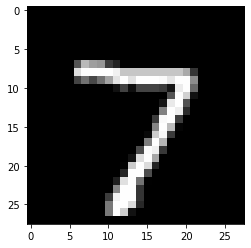

In [6]:
plt.imshow(testx[0], cmap='gray')

In [7]:
def preprocess_fn(image):
    mean= [0.13101533792088266]
    std= [0.3085401559245608]
    
#     image = cv2.imread(image_path)
    #print(image.shape)
#     image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image= np.expand_dims(image, axis=0)
    image= image.squeeze()
    #image= np.transpose(image, (1, 2, 0))
    #print(image.shape)
#     print(image.max())
#     print(image.min())
#     image= image.astype('float32')
    image = image * (1/255.0)
#     image= (image-mean)/std
    image = image.reshape(4,14,14)
#     print(image.max())
#     print(image.min())

#     image= image* fix_scale
#     image= image.astype(np.int8)
    return image

In [8]:
def desnorm(image):
    mean= [0.13101533792088266]
    std= [0.3085401559245608]
#     image= image*std+mean
    image = image.reshape(28,28,1)
    return image

In [9]:
# labels= []
# for file in files:
#     labels.append(file.split("_")[0])

In [10]:
# index= 0
# image_path= os.path.join(images_path, files[index])
# image = cv2.imread(image_path)

# mean= [0.485, 0.456, 0.406]
# std= [0.229, 0.224, 0.225]
# image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #image = image.reshape(32,32,3)
# image = image * (1/255.0)
# image= (image-mean)/std
# image.max(), image.min()
# #plt.imshow(image)
# #print(labels[index])

In [11]:
index= 0
# image_path= os.path.join(images_path, files[index])
#print(image_path)
img_pre= preprocess_fn(testx[index])
img_pre.shape

(4, 14, 14)

In [12]:
test_data= np.empty((len(testx),4,14,14))
#test_data.shape
# i=0
for i in range(len(testx)):
    
    image= testx[i]
    img_pre= preprocess_fn(image)
    test_data[i,...]= img_pre
#     i+=1

In [13]:
testx[0].shape

(28, 28, 1)

In [14]:
testy[0]

7

In [15]:
import numpy as np

In [16]:
test_data.shape[1]

4

In [17]:
Mean= np.empty(len(test_data))
Std= np.empty(len(test_data))
for i in range(len(test_data)):
    Mean[i]=test_data[i].mean()
    Std[i]=test_data[i].std()
    
print(Mean.mean())
print(Std.mean())

0.13251460584233693
0.3036607680488869


In [18]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

In [19]:
inputTensors[0].dims

[1, 4, 14, 14]

In [20]:
shapeIn, shapeOut

((1, 4, 14, 14), (1, 10))

In [21]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

In [22]:
input_data[0].shape

(1, 4, 14, 14)

In [23]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

In [24]:
test_data.shape

(10000, 4, 14, 14)

In [25]:
image[0,...] = test_data[0]

image.shape

(1, 4, 14, 14)

In [26]:
classes = ['zero', 'one' , 'two',
    'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine']

clases_np= np.array(classes)

In [27]:
test_data[1,:,:,:].shape

#desnorm(test_data[1,:,:,:])

(4, 14, 14)

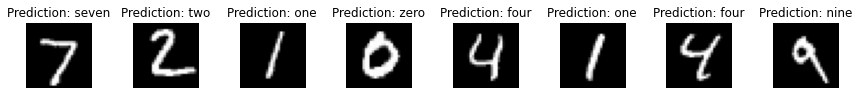

In [28]:
num_pics  = 8
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    prediction = softmax.argmax()

    ax[i].set_title('Prediction: ' + classes[prediction])
    ax[i].axis('off')
    ax[i].imshow(desnorm(test_data[i,:,:,:]), cmap='gray')

In [29]:
total = test_data.shape[0]
test_label=testy
predictions = np.empty_like(test_label)
print("Classifying {} digit pictures ...".format(total))
correct=0
start = time()
for i in range(total):
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    
    softmax = calculate_softmax(temp[0][0])
#     print(softmax.argmax())
    predictions[i] = softmax.argmax()
    if predictions[i]==test_label[i]:
        correct+=1
#     else:
#         print(i)
stop = time()
#correct = np.sum(clases_np[predictions]==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

Classifying 10000 digit pictures ...
Overall accuracy: 0.9653
  Execution time: 7.1789s
      Throughput: 1392.9635FPS


In [30]:
def latency_measurement():
    image[0,...] = test_data[0]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions  = softmax.argmax()

In [31]:
one_image_validation_time = %timeit -n 1 -o latency_measurement()

822 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
del overlay


In [33]:
del dpu